In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from PIL import Image

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# Load the training dataset
trainset = torchvision.datasets.ImageFolder(root='/home/ec/Downloads/New Plant Diseases Dataset(Augmented)/train/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)


In [3]:
# Define the SqueezeNet model
model = torchvision.models.squeezenet1_1(pretrained=False)
num_classes = len(trainset.classes)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.num_classes = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Move the model to the appropriate device
model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

[Epoch 1, Batch   100] loss: 2.286, accuracy: 11.91%
[Epoch 1, Batch   200] loss: 2.127, accuracy: 16.42%
[Epoch 1, Batch   300] loss: 1.927, accuracy: 20.51%
[Epoch 1, Batch   400] loss: 1.801, accuracy: 23.36%
[Epoch 1, Batch   500] loss: 1.594, accuracy: 26.37%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Finished Epoch 1
[Epoch 2, Batch   100] loss: 1.427, accuracy: 46.91%
[Epoch 2, Batch   200] loss: 1.352, accuracy: 47.88%
[Epoch 2, Batch   300] loss: 1.287, accuracy: 49.81%
[Epoch 2, Batch   400] loss: 1.246, accuracy: 51.02%
[Epoch 2, Batch   500] loss: 1.174, accuracy: 52.19%
Finished Epoch 2
[Epoch 3, Batch   100] loss: 0.987, accuracy: 64.47%
[Epoch 3, Batch   200] loss: 0.975, accuracy: 64.52%
[Epoch 3, Batch   300] loss: 0.930, accuracy: 65.33%
[Epoch 3, Batch   400] loss: 0.875, accuracy: 66.47%
[Epoch 3, Batch   500] loss: 0.822, accuracy: 67.36%
Finished Epoch 3
[Epoch 4, Batch   100] loss: 0.758, accuracy: 73.78%
[Epoch 4, Batch   200] loss: 0.742, accuracy: 73.58%
[Epoch 4, Batch   300] loss: 0.703, accuracy: 73.97%
[Epoch 4, Batch   400] loss: 0.613, accuracy: 75.05%
[Epoch 4, Batch   500] loss: 0.646, accuracy: 75.43%
Finished Epoch 4
[Epoch 5, Batch   100] loss: 0.589, accuracy: 79.25%
[Epoch 5, Batch   200] loss: 0.531, accuracy: 79.92%
[Epoch 5, Batch   300] loss: 0.

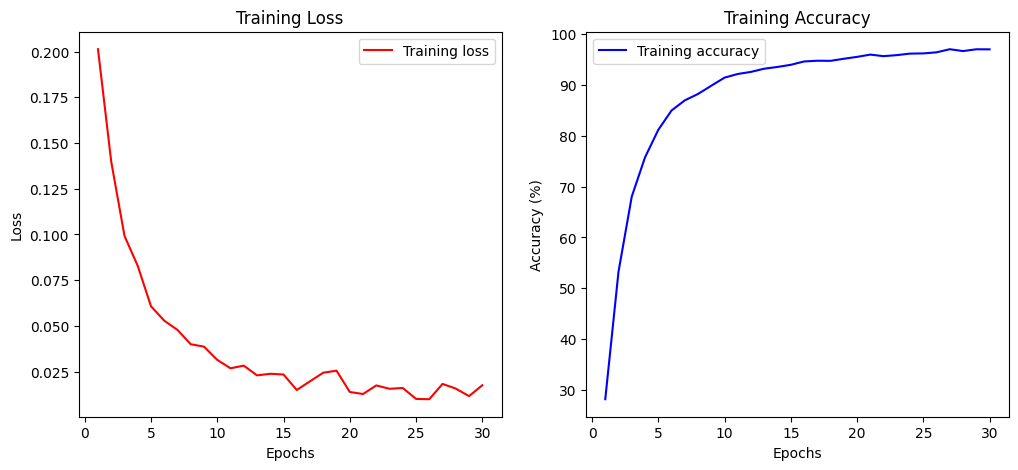

In [6]:
import matplotlib.pyplot as plt

num_epochs = 30
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[Epoch %d, Batch %5d] loss: %.3f, accuracy: %.2f%%' %
                  (epoch + 1, i + 1, running_loss / 100, 100 * correct / total))
            running_loss = 0.0

    # Calculate average epoch training loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print('Finished Epoch %d' % (epoch + 1))

print('Finished Training')

# Plotting the training loss and accuracy graphs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [7]:
# Save the trained model
torch.save(model.state_dict(), '/home/ec/Downloads/squeezenet1_1_plant_disease.pth')

In [8]:
# Define transforms for the test dataset
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Load the test dataset
testset = torchvision.datasets.ImageFolder(root='/home/ec/Downloads/New Plant Diseases Dataset(Augmented)/valid/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


In [10]:
# Load the trained model weights
model.load_state_dict(torch.load('/home/ec/Downloads/squeezenet1_1_plant_disease.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Accuracy of the network on the test images: 91 %
Confusion Matrix:
[[335  10   6   0   2   2   5  65   0   0]
 [  2 394  31   3   6   1  23  17   3   0]
 [  1  19 409   5  10   4   5   7   1   2]
 [  0   1   3 452   2   9   0   1   1   1]
 [  1   5   2   5 390   2  14   2  15   0]
 [  0   1   1   0   0 401  10  15   7   0]
 [  0   2   0   0   1  27 408   1  12   6]
 [  1   1   1   0   0   1   0 486   0   0]
 [  0   0   0   0   0   0   2   0 444   2]
 [  2   0   4   0   0   0   2   0   0 473]]


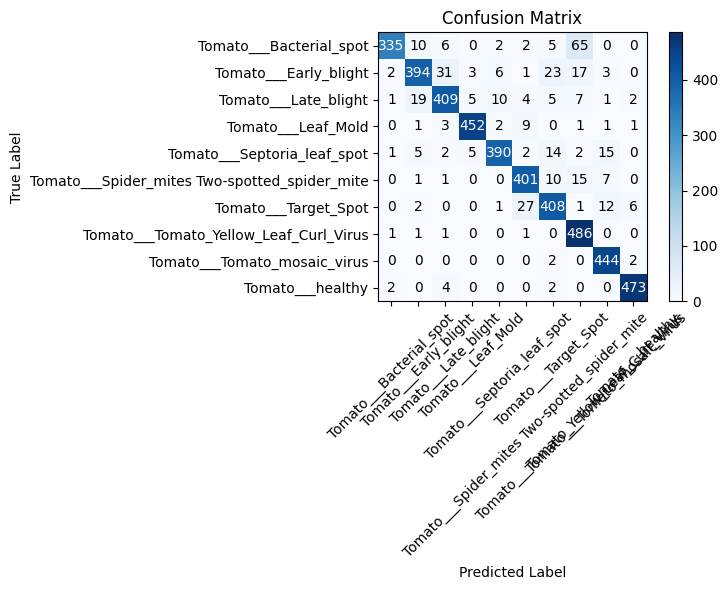

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.79      0.87       425
                        Tomato___Early_blight       0.91      0.82      0.86       480
                         Tomato___Late_blight       0.89      0.88      0.89       463
                           Tomato___Leaf_Mold       0.97      0.96      0.97       470
                  Tomato___Septoria_leaf_spot       0.95      0.89      0.92       436
Tomato___Spider_mites Two-spotted_spider_mite       0.90      0.92      0.91       435
                         Tomato___Target_Spot       0.87      0.89      0.88       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.82      0.99      0.90       490
                 Tomato___Tomato_mosaic_virus       0.92      0.99      0.95       448
                             Tomato___healthy       0.98      0.98      0.98       481

                  

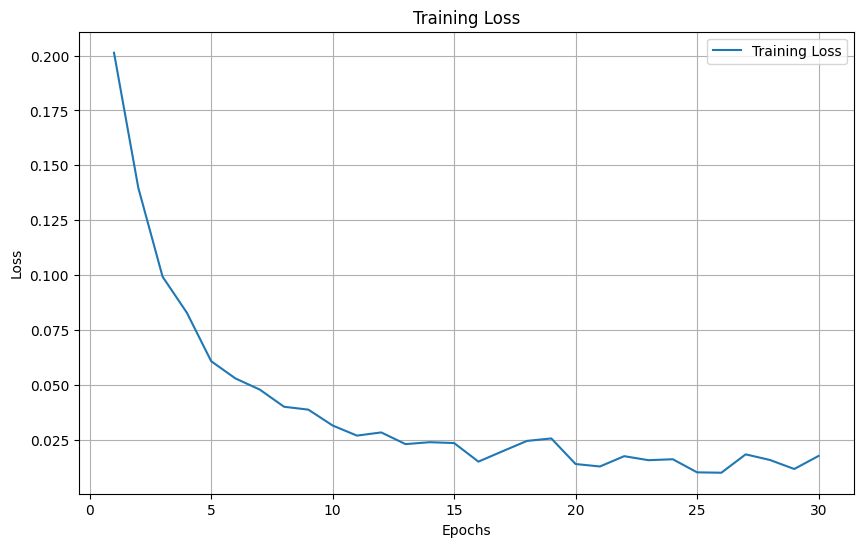

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():  # No need to track gradients for validation
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Append predicted and true labels to lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy of the network on the test images: %d %%' % accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix with values
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(trainset.classes))
plt.xticks(tick_marks, trainset.classes, rotation=45)
plt.yticks(tick_marks, trainset.classes)

# Print values on the matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha='center', va='center',
             color='white' if conf_matrix[i, j] > thresh else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Calculate precision, recall, f1-score, support
report = classification_report(true_labels, predicted_labels, target_names=trainset.classes)
print('Classification Report:')
print(report)

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Function to predict the disease from a given image path
def predict_image(image_path, model, transform, classes):
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Transform and add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return classes[predicted.item()]

# Example usage:
# Replace 'your_image_path.jpg' with the actual image path
image_path='/home/ec/Downloads/testing_imges/image.JPG'
predicted_class = predict_image(image_path, model, transform, trainset.classes)
print(f'The disease in the image is: {predicted_class}')


The disease in the image is: Tomato___Bacterial_spot


In [43]:
import os
from PIL import Image

# Function to predict the disease from a list of image paths
def predict_images(image_paths, model, transform, classes):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    
    for image_path in image_paths:
        if os.path.exists(image_path):
            image = Image.open(image_path)  # Open the image file
            image = transform(image).unsqueeze(0)  # Transform and add batch dimension
            image = image.to(device)
            
            with torch.no_grad():
                outputs = model(image)
                _, predicted = torch.max(outputs, 1)
            
            predicted_class = classes[predicted.item()]
            predictions.append((image_path, predicted_class))
        else:
            print(f'File does not exist: {image_path}')
            predictions.append((image_path, 'File not found'))
    
    return predictions

# Example usage:
# Replace these with actual image paths
image_paths = [
    '/home/ec/Downloads/testing_imges/Leaf_mold.JPG',
    '/home/ec/Downloads/testing_imges/Leaf_mold2.JPG',
    '/home/ec/Downloads/testing_imges/Mosaic_virus.JPG',
     '/home/ec/Downloads/testing_imges/Septoria_leaf_spot.JPG',
     '/home/ec/Downloads/testing_imges/Septoria_leaf_spot2.JPG',
     '/home/ec/Downloads/testing_imges/Target_spot1.JPG',
     '/home/ec/Downloads/testing_imges/Target_spot2.JPG',
     '/home/ec/Downloads/testing_imges/Tomato_Bacterial_spot1.JPG',
     '/home/ec/Downloads/testing_imges/Tomato_Bacterial_spot2.JPG',
     '/home/ec/Downloads/testing_imges/Tomato_Bacterial_spot3.JPG',
    '/home/ec/Downloads/testing_imges/Tomato_Early_blight1.JPG',
     '/home/ec/Downloads/testing_imges/Tomato_Early_blight2.JPG',
     '/home/ec/Downloads/testing_imges/Yellow_leaf_curl_virus.JPG',
     '/home/ec/Downloads/testing_imges/Yellow_leaf_curl_virus2.JPG',
     '/home/ec/Downloads/testing_imges/healthy1.JPG',
    '/home/ec/Downloads/testing_imges/healthy2.JPG',
    # Add more image paths as needed
]

# Predict diseases for the images
predictions = predict_images(image_paths, model, transform, trainset.classes)

# Print the predictions
for path, prediction in predictions:
    print(f'The disease in the image {path} is: {prediction}')


The disease in the image /home/ec/Downloads/testing_imges/Leaf_mold.JPG is: Tomato___Leaf_Mold
The disease in the image /home/ec/Downloads/testing_imges/Leaf_mold2.JPG is: Tomato___Leaf_Mold
The disease in the image /home/ec/Downloads/testing_imges/Mosaic_virus.JPG is: Tomato___Tomato_mosaic_virus
The disease in the image /home/ec/Downloads/testing_imges/Septoria_leaf_spot.JPG is: Tomato___Septoria_leaf_spot
The disease in the image /home/ec/Downloads/testing_imges/Septoria_leaf_spot2.JPG is: Tomato___Septoria_leaf_spot
The disease in the image /home/ec/Downloads/testing_imges/Target_spot1.JPG is: Tomato___Target_Spot
The disease in the image /home/ec/Downloads/testing_imges/Target_spot2.JPG is: Tomato___Target_Spot
The disease in the image /home/ec/Downloads/testing_imges/Tomato_Bacterial_spot1.JPG is: Tomato___Bacterial_spot
The disease in the image /home/ec/Downloads/testing_imges/Tomato_Bacterial_spot2.JPG is: Tomato___Bacterial_spot
The disease in the image /home/ec/Downloads/test

In [ ]:
# Function to predict the disease from a list of image paths and print additional outputs
def predict_images(image_paths, model, transform, classes, top_k=5):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []

    for image_path in image_paths:
        if os.path.exists(image_path):
            image = Image.open(image_path)  # Open the image file
            image = transform(image).unsqueeze(0)  # Transform and add batch dimension
            image = image.to(device)

            with torch.no_grad():
                outputs = model(image)
                probabilities = F.softmax(outputs, dim=1)
                top_probs, top_classes = probabilities.topk(top_k, dim=1)
                top_probs = top_probs.cpu().numpy().flatten()
                top_classes = top_classes.cpu().numpy().flatten()

                _, predicted = torch.max(outputs, 1)
                predicted_class = classes[predicted.item()]
                predicted_probability = probabilities[0][predicted.item()].item()
                
                predictions.append((image_path, predicted_class, predicted_probability, top_classes, top_probs))
                all_predicted_labels.append(predicted.item())
                all_probabilities.append(probabilities.cpu().numpy())
        else:
            print(f'File does not exist: {image_path}')
            predictions.append((image_path, 'File not found', 0, [], []))

    return predictions, all_predicted_labels, all_probabilities

# Example usage:
# Replace these with actual image paths
image_paths = [
    '/home/ec/Downloads/testing_images/image1.jpg',
    '/home/ec/Downloads/testing_images/image2.jpg',
    '/home/ec/Downloads/testing_images/image3.jpg',
    # Add more image paths as needed
]

# Predict diseases for the images
predictions, all_predicted_labels, all_probabilities = predict_images(image_paths, model, transform, trainset.classes, top_k=5)

# Print the predictions with image labels and probabilities
for path, prediction, probability, top_classes, top_probs in predictions:
    print(f'The disease in the image {path} is: {prediction} with probability {probability:.4f}')
    for cls, prob in zip(top_classes, top_probs):
        print(f'  Top class: {trainset.classes[cls]} with probability {prob:.4f}')


In [39]:
# Print model summary
print(model)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [40]:
# ROC Curve and AUC Score
# Binarize labels for ROC curve calculation
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
outputs_np = np.concatenate(all_probabilities, axis=0)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], outputs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(true_labels_bin.ravel(), outputs_np.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], trainset.classes[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print('AUC Score:')
for i in range(num_classes):
    print(f'Class {trainset.classes[i]}: {roc_auc[i]:.2f}')
print(f'Micro-average: {roc_auc_micro:.2f}')


NameError: name 'all_probabilities' is not defined

In [41]:
model.save('trained_model.h5')

AttributeError: 'SqueezeNet' object has no attribute 'save'